# Benchmarking motif networks for the reconstruction of kidney cancer regulatory network

Marouen Ben Guebila<sup>1</sup>

<sup>1</sup> Department of Biostatistics, Harvard T.H. Chan School of Public Health, Boston, MA.

# Introduction

In a [previous tutorial](Building_a_regulation_prior_network.ipynb), we built motif prior networks based on TF motif and target gene sequences using four different approaches. In this step, we will build a PANDA<sup>1</sup> Kidney Renal Clear Cell Carcinoma (KRCC) gene regulatory network using as input the four motif prior networks and we will benchmark the four final networks in terms of:

- Dependence on initial conditions
- Modularity score
- GO term enrichment analysis
- ChIP-seq accuracy

PANDA uses three inputs to compute a gene regulatory network:
- A TF-gene regulation network that will be one of the four matrices that we [computed previsouly](Building_a_regulation_prior_network.ipynb).  
- A gene coexpression matrix to provide regulation context. We will use the KRCC gene expression data from the TCGA<sup>2</sup> project that we [processed previously](../netZooR/gene_expression_for_coexpression_nets.ipynb) by controlling the variance between samples to compute a normalized coexpression matrix.
- A TF PPI network extracted from StringDB<sup>3</sup> that informs about TF regulatory complexes.

Let's start first by loading the required packages.

In [1]:
import pandas as pd # to load adjacency matrices
import numpy as np
import json
import requests # to query enrichr
from netZooPy import condor
from netZooPy.panda.panda import Panda # to build a GRN network
import matplotlib.pyplot as plt # for plotting
from sklearn.metrics import roc_curve, auc # for auroc plotting
from sklearn.metrics import average_precision_score # to compute precision score

## Building KRCC regulatory networks

Since we are benchmarking KRCC networks by varying the regulatory prior matrix, the two other inputs (the coexpression matrix and the PPI matrix) are fixed. We can start first by loading them. The expression data has 25224 genes over 544 samples. We will skip the PANDA computation part because it takes some time, however, we will provide the computed network for the following analyses. We will use the `intersection` mode of PANDA that takes the intersection of genes and TFs in the three input networks to build four regulatory network based on each of the four motif regulatory networks. The regulatory network built using the `intersection` mode yields a final model of 1132 TFs targeting 24815 genes.

As a reminder the four motif networks are one binary network and three continuous networks: Garcia-Alonso model (continuous prior 1), Ouyang model (continuous prior 2), and the Regulatory Potential (RP) model (continuous prior 3). The three continuous networks were processed by quantile normalization followed by scaling between 0 and 1.

In [ ]:
expression_data = pd.read_csv('/opt/data/netZooPy/krcc/scaled_gene_expression_KRCC.csv')

In [ ]:
ppi_data = pd.read_csv('/opt/data/netZooPy/krcc/ppi_complete.txt',sep='\t',header=None,index_col=None)

### Continuous prior 1

In [4]:
motif_dataCont1 = pd.read_csv('regMatCont1Processed.csv',index_col=0)
meltedmotifCont1=motif_dataCont1.stack().reset_index().rename(columns={'level_0':'source','level_1':'target', 0:'weight'})
#KRCCNetCont1 = Panda(expression_data, meltedmotifCont1, ppi_data, modeProcess='intersection', save_memory=False)
#KRCCNetCont1 = pd.DataFrame(KRCCNetCont1.panda_network, index=KRCCNetCont1.unique_tfs, columns=KRCCNetCont1.gene_names)

In [5]:
KRCCNetCont1 = pd.read_csv('KRCC_contprior1.csv',index_col=0)

### Continuous prior 2

In [7]:
motif_dataCont2 = pd.read_csv('regMatCont2Processed.csv',index_col=0)
meltedmotifCont2=motif_dataCont2.stack().reset_index().rename(columns={'level_0':'source','level_1':'target', 0:'weight'})
#KRCCNetCont2 = Panda(expression_data, meltedmotifCont2, ppi_data, modeProcess='intersection', save_memory=False)
#KRCCNetCont2 = pd.DataFrame(KRCCNetCont2.panda_network, index=KRCCNetCont2.unique_tfs, columns=KRCCNetCont2.gene_names)

In [6]:
KRCCNetCont2 = pd.read_csv('KRCC_contprior2.csv',index_col=0)

### Continuous prior 3

In [9]:
motif_dataCont3 = pd.read_csv('regMatCont3Processed.csv',index_col=0)
meltedmotifCont3=motif_dataCont3.stack().reset_index().rename(columns={'level_0':'source','level_1':'target', 0:'weight'})
#KRCCNetCont3 = Panda(expression_data, meltedmotifCont3, ppi_data, modeProcess='intersection', save_memory=False)
#KRCCNetCont3 = pd.DataFrame(KRCCNetCont3.panda_network, index=KRCCNetCont3.unique_tfs, columns=KRCCNetCont3.gene_names)

In [8]:
KRCCNetCont3 = pd.read_csv('KRCC_contprior3.csv',index_col=0)

### Binary prior 

In [10]:
motif_dataBin1 = pd.read_csv('regMatBin1thr005.csv',index_col=0)
meltedmotifBin1=motif_dataBin1.stack().reset_index().rename(columns={'level_0':'source','level_1':'target', 0:'weight'})
#KRCCNetBin1 = Panda(expression_data, meltedmotifBin1, ppi_data, modeProcess='intersection', save_memory=False)
#KRCCNetBin1 = pd.DataFrame(KRCCNetBin1.panda_network, index=KRCCNetBin1.unique_tfs, columns=KRCCNetBin1.gene_names)

In [11]:
KRCCNetBin1 = pd.read_csv('KRCC_binprior1.csv',index_col=0)

# Benchmarking the regulatory networks
## 1. Dependence on motif prior

A key aspect to explore is the dependence of the final network on the initial motif prior networks. In other words, which edges were up-scored or down-scored in the motif prior network by integrating data from the PPI and coexpression networks.

### Binary motif prior networks

In [ ]:
bins = np.linspace(-5, 10, 1000)
df = motif_dataBin1.loc[motif_dataBin1.index.isin(KRCCNetBin1.index),motif_dataBin1.columns.isin(KRCCNetBin1.columns)]
KRCCNetBin1.sort_index(inplace=True)
KRCCNetBin1.sort_index(axis=1,inplace=True)
df.sort_index(inplace=True)
df.sort_index(axis=1,inplace=True)
cc=KRCCNetBin1.values.flatten()
dd=KRCCNetBin1.values.flatten()[df.values.flatten()==1]

#fig=plt.figure(figsize=(4,4), dpi= 100, facecolor='w', edgecolor='k')
plt.hist([cc,dd], bins);
plt.xlabel('Edge weight');
plt.ylabel('Frequency');
plt.legend(['all edges','motif edges']);

In [ ]:
fpr, tpr, _ = roc_curve(df.values.flatten(), KRCCNetBin1.values.flatten())
roc_auc = auc(fpr, tpr)
print("AUROC is ",roc_auc)

In [ ]:
plt.plot(fpr,tpr);
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');

We see that binary motifs produce gene regulatory networks that are entirely determined by the initial network. In the first figure, we see that the distribution of the final network is bimodal, which is reminiscient from the binary structure of the initial network. We can see that clearly when we map the edges in the final network to the edges in the motif network that had a value of one. In other words, the final network retains the original structure of the motif network. This can be further demonstrated by computing the AUROC of the classification of motif edges by the final network edges. In this case, AUROC is equal to 1, which shows that final network is undistinguishable from the initial network.

### Continuous motif prior networks
Plotting the distribution of the network edges that were computed using continuous motif prior, shows that they are distributed using a unimodal distribution that can be probably approached by a Gaussian distribution. This can help in downstream analyses as several analytical tools assumes a normal distribution of the underlying data.

Text(0.5, 1.0, 'Edge weight distribution in continuous network 3')

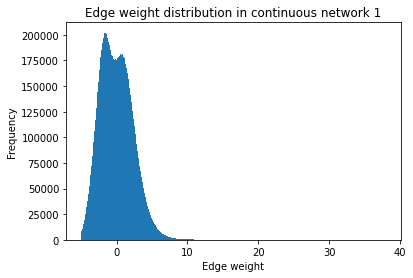

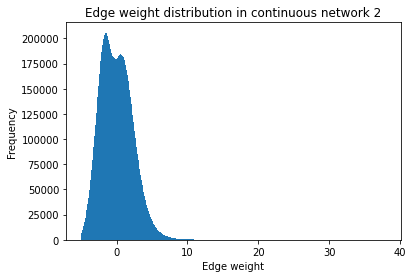

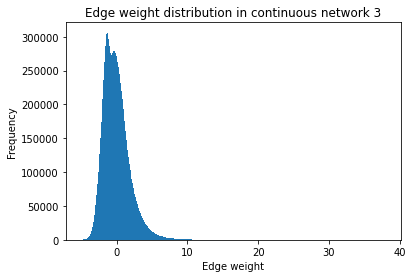

In [12]:
bins = np.linspace(-5, 38, 1000)
plt.hist(KRCCNetCont1.values.flatten(), bins);
plt.xlabel('Edge weight')
plt.ylabel('Frequency')
plt.title('Edge weight distribution in continuous network 1')

plt.figure()
plt.hist(KRCCNetCont2.values.flatten(), bins);
plt.xlabel('Edge weight')
plt.ylabel('Frequency')
plt.title('Edge weight distribution in continuous network 2')

plt.figure()
plt.hist(KRCCNetCont3.values.flatten(), bins);
plt.xlabel('Edge weight')
plt.ylabel('Frequency')
plt.title('Edge weight distribution in continuous network 3')

In [13]:
KRCCNetCont1.sort_index(inplace=True)
KRCCNetCont1.sort_index(axis=1,inplace=True)
df1 = motif_dataCont1.loc[motif_dataCont1.index.isin(KRCCNetCont1.index),motif_dataCont1.columns.isin(KRCCNetCont1.columns)]
df1.sort_index(inplace=True)
df1.sort_index(axis=1,inplace=True)

In [14]:
KRCCNetCont2.sort_index(inplace=True)
KRCCNetCont2.sort_index(axis=1,inplace=True)
df2 = motif_dataCont2.loc[motif_dataCont2.index.isin(KRCCNetCont2.index),motif_dataCont2.columns.isin(KRCCNetCont2.columns)]
df2.sort_index(inplace=True)
df2.sort_index(axis=1,inplace=True)

In [15]:
KRCCNetCont3.sort_index(inplace=True)
KRCCNetCont3.sort_index(axis=1,inplace=True)
df3 = motif_dataCont3.loc[motif_dataCont3.index.isin(KRCCNetCont3.index),motif_dataCont3.columns.isin(KRCCNetCont3.columns)]
df3.sort_index(inplace=True)
df3.sort_index(axis=1,inplace=True)

[[1.         0.55516905]
 [0.55516905 1.        ]]
[[1.         0.54243048]
 [0.54243048 1.        ]]
[[1.         0.77082632]
 [0.77082632 1.        ]]


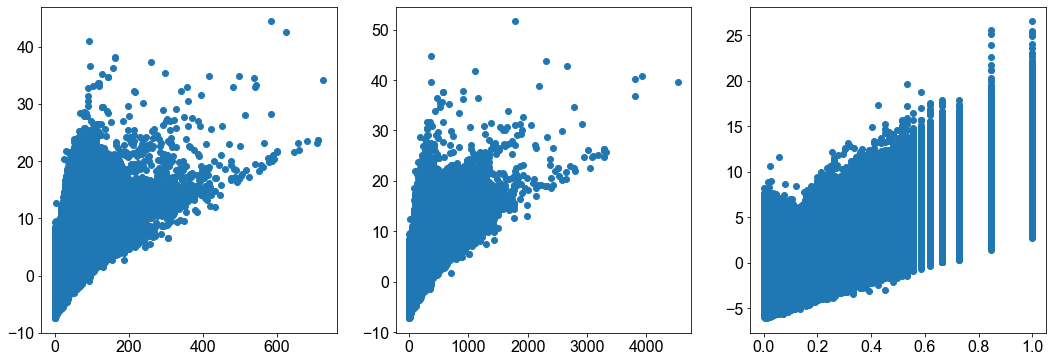

In [20]:
plt.rcParams["font.family"] = "arial"
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(18, 6))


ax1.plot(df1.values.flatten(),KRCCNetCont1.values.flatten(), 'o');
ax1.tick_params(axis='both', which='major', labelsize=16)
print(np.corrcoef(df1.values.flatten(),KRCCNetCont1.values.flatten()))



ax2.plot(df2.values.flatten(),KRCCNetCont2.values.flatten(), 'o');
ax2.tick_params(axis='both', which='major', labelsize=16)
print(np.corrcoef(df2.values.flatten(),KRCCNetCont2.values.flatten()))



ax3.plot(df3.values.flatten(),KRCCNetCont3.values.flatten(), 'o');
ax3.tick_params(axis='both', which='major', labelsize=16)
print(np.corrcoef(df3.values.flatten(),KRCCNetCont3.values.flatten()))

#fig.text(0.5, 0.04, 'Edge weight in final network', ha='center')
#fig.text(0.04, 0.5, 'Edge weight in motif prior', va='center', rotation='vertical')
#plt.suptitle('Correlation between motif prior edge weights and continuous network 1 edge weights');
plt.savefig('/Users/mab8354/motifPaper/paper/figures/figure6/figure6.png',format='png')






In networks generated with continuous motif priors, we can see that the correlation between the final network edges and the prior networks edges is 0.5 for the first and second networks and 0.77 for the third networks. In other words,  the final network does retain some structure from the input network but it is not completely determined by the initial network. We can see for example that edges that started with a low score in the initial network can be upweighted in the final network using the updated information from the two other inputs: PPI and coexpression networks.

However, there is a bias to be noted here, the edges that have a low score initially can be upweighted in the final network, but the opposite is not correct. The edges that start with a high score will not be down-weighted. This is inherent to PANDA, the reconstruction method, rather than the nature of the input matrices. The bias can be noted also in the distribution of the final edges, that shows a centered yet assymetrical distribution with a heavier tail in the positive values.

## 2. Community detection
Now we will compare the four final regulatory networks in their ability to form clusters by computing their modularity. Biological networks are highly modular, therefore, we expect this property to be reflected in the final network. We will use CONDOR<sup>4</sup> to compute the modularity score and assign communities in the final networks.

In [ ]:
modVec, percVec = [], []
for net in [motif_dataBin1, KRCCNetBin1, motif_dataCont1, KRCCNetCont1, motif_dataCont2, KRCCNetCont2, motif_dataCont3, KRCCNetCont3]:
    net = net.stack().reset_index();
    net['level_0']=net['level_0']+'_tf'
    numEdges=len(net.iloc[:,2])
    net =net[net.iloc[:,2]>=0];
    percVec.append(len(net.iloc[:,2])/a)
    condor_object = condor.condor_object(net);
    condor_object.keys();
    condor_object = condor.initial_community(condor_object);
    condor_object = condor.brim(condor_object,deltaQmin="def");
    modVec.append(condor_object['modularity']);

In [ ]:
labels = ['Binary', 'Continuous 1','Continuous 2','Continuous 3']
bin_means = [modVec[0], modVec[2],modVec[4],modVec[6]]
cont_means = [modVec[1], modVec[3],modVec[5],modVec[7]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bin_means, width, label='Motif prior')
rects2 = ax.bar(x + width/2, cont_means, width, label='PANDA network')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Modularity score')
ax.set_title('Modularity score of the motif prior and final networks')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

By computing the modularity scores of the final networks using CONDOR, we see that all the initial motif prior networks have a low modularity score (~0.15). However, the network based on binary motif prior still has a low modularity (0.24). The networks that are based on continuous motif priors have a much larger modularity (0.39-0.44) which is expected in biological networks.

Since CONDOR takes only positive edges in the network, there could be a bias in the modularity score towards the number of positive edges in each network.

In [ ]:
labels = ['Binary', 'Continuous 1','Continuous 2','Continuous 3']
bin_means = [percVec[0], percVec[2],percVec[4],percVec[6]]
cont_means = [percVec[1], percVec[3],percVec[5],percVec[7]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bin_means, width, label='Motif prior')
rects2 = ax.bar(x + width/2, cont_means, width, label='PANDA network')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Percentage of positive edges as input to CONDOR')
ax.set_ylabel('Percentage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
targetDen=np.min(cont_means)

We see that all motif priors have 100% of positive edges, therefore their scores are comparable. However, positive edges in final PANDA networks vary between 28%-47%. We need to balance the number of positive edges to obtain comparable modularity score by taking the top 28% positive edges in PANDA networks.

In [ ]:
modVecCorrected = []
fracEdges=int(targetDen*numEdges)
for net in [KRCCNetBin1, KRCCNetCont1, KRCCNetCont2, KRCCNetCont3]:
    net = net.stack().reset_index();
    net['level_0']=net['level_0']+'_tf'
    net.sort_values(0, axis=0, ascending=False, inplace=True)
    net =net[0:fracEdges];
    condor_object = condor.condor_object(net);
    condor_object.keys();
    condor_object = condor.initial_community(condor_object);
    condor_object = condor.brim(condor_object,deltaQmin="def");
    modVecCorrected.append(condor_object['modularity']);

In [ ]:
labels = ['Binary', 'Continuous 1','Continuous 2','Continuous 3']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, modVecCorrected, width, label='PANDA networks')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Balanced modularity score')
ax.set_ylabel('Modularity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

After correcting for the number of positive edges, we see that modularity scores are similar to our previous result, highlighting that the improved modularity is inherent to the network itself rather than a selection bias.

## 3. Gene enrichment analysis
The next benchmark is testing the top weighted genes in the network in Gene Ontology (GO) biological processes. We picked the top 100 genes in each network by their differential targeting score<sup>5</sup>, which the sum of the weighted outgree of each gene and queried Enrichr<sup>6</sup> using the web API.

In [ ]:
j=-1
titleArray=['Binary network 100 genes','Continous network 1 100 genes','Continous network 2 100 genes','Continous network 3 100 genes']
for net in [KRCCNetBin1,KRCCNetCont1,KRCCNetCont2,KRCCNetCont3]:
    j=j+1
    a=net.values.sum(axis=0)
    b=np.argsort(-a)
    c=net.columns[b[0:100]]
    genes_str='\n'.join(c)
    ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
    query_string = '?userListId=%s&backgroundType=%s'

    description = 'Example gene list'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')

    data = json.loads(response.text)

    user_list_id = data['userListId']
    gene_set_library = 'GO_Biological_Process_2018'
    ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
    response = requests.get(
        ENRICHR_URL + query_string % (user_list_id, gene_set_library)
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text);
    processBio=[]
    pvals=[]
    for i in range(1,10):
        processBio.append(data['GO_Biological_Process_2018'][i][1])
        pvals.append(data['GO_Biological_Process_2018'][i][2])
    plt.figure()
    y_pos = np.arange(len(processBio))
    plt.barh(y_pos, -np.log10(pvals))
    plt.yticks(ticks=y_pos,labels=processBio);
    plt.gca().invert_yaxis()  
    plt.xlabel('-log(p-value)')
    plt.title(titleArray[j])

In this case, we see that there aren't differences in the enriched terms between the networks. Usually, one network does not capture the context, but it is rather a differential network in a case vs control setting that allows to do so. In our case, we need to analyze the KRCC network using a background network of healthy kidney for example, to be able to get an enrichment of cancer-specific processes or terms related to kidney physiology.

## 4. Validation on ChIP-seq
We can also look at the performance of the final networks in classifying ChIP-seq binding events. First, we download ChIP-seq peaks from Remap 2020<sup>7</sup> database, which aggregated many ChIP-seq experiments and processed them using a uniform pipeline. Then, we identify the peaks that correspond to the binding of a TF in the TSS+/-1kb region, which matches our search sequence in the motif prior that we computed to generate the networks.

In [ ]:
chip=pd.read_csv('/opt/data/netZooPy/krcc/ChIP_seq_HEK293.csv',index_col=0)

In [ ]:
chip.sort_index(inplace=True)
chip.sort_index(axis=1,inplace=True)

KRCCNetCont1.sort_index(inplace=True)
KRCCNetCont1.sort_index(axis=1,inplace=True)

KRCCNetCont2.sort_index(inplace=True)
KRCCNetCont2.sort_index(axis=1,inplace=True)

KRCCNetCont3.sort_index(inplace=True)
KRCCNetCont3.sort_index(axis=1,inplace=True)

KRCCNetBin1.sort_index(inplace=True)
KRCCNetBin1.sort_index(axis=1,inplace=True)

commonTFs  = chip.index[chip.index.isin(KRCCNetCont3.index)]
commonGenes= chip.columns[chip.columns.isin(KRCCNetCont3.columns)]

df=chip.loc[commonTFs, commonGenes]
df0=KRCCNetBin1.loc[commonTFs, commonGenes]
df1=KRCCNetCont1.loc[commonTFs, commonGenes]
df2=KRCCNetCont2.loc[commonTFs, commonGenes]
df3=KRCCNetCont3.loc[commonTFs, commonGenes]

In [ ]:
fpr, tpr, _ = roc_curve(df.values.flatten(), df1.values.flatten())
roc_aucCont1 = auc(fpr, tpr)
print("AUROC for continuous network 1 is ",roc_aucCont1)
fpr, tpr, _ = roc_curve(df.values.flatten(), df2.values.flatten())
roc_aucCont2 = auc(fpr, tpr)
print("AUROC for continuous network 2 is ",roc_aucCont2)
fpr, tpr, _ = roc_curve(df.values.flatten(), df3.values.flatten())
roc_aucCont3 = auc(fpr, tpr)
print("AUROC for continuous network 3 is ",roc_aucCont3)
fpr, tpr, _ = roc_curve(df.values.flatten(), df0.values.flatten())
roc_aucBin = auc(fpr, tpr)
print("AUROC for binary network is ",roc_aucBin)

In [ ]:
average_precisionBin = average_precision_score(
...     df.values.flatten(), df0.values.flatten())
average_precisionCont1 = average_precision_score(
...     df.values.flatten(), df1.values.flatten())
average_precisionCont2 = average_precision_score(
...     df.values.flatten(), df2.values.flatten())
average_precisionCont3 = average_precision_score(
...     df.values.flatten(), df3.values.flatten())

In [ ]:
print('Average precision score for binary network is',average_precisionBin)
print('Average precision score for continuous network 1 is',average_precisionCont1)
print('Average precision score for continuous network 2 is',average_precisionCont2)
print('Average precision score for continuous network 3 is',average_precisionCont3)

Comparing the performance of each network in identifying ChIP-seq binding using AUROC and AUPR metrics shows that all four networks perform equally bad. In a different work, we found that perfromance against ground truth can be tuned by choosing the optimal parameter set using Bayesian Optimization in a [method  called optPANDA](https://github.com/netZoo/netZooM/tree/master/tutorials/opt_panda).

# Summary

Taken together, we see that using continuous prior motif networks allow the generation of improved PANDA gene regulatory networks in terms of:

- Better modularity (0.24 binary versus 0.39 to 0.44 in continuous)
- Less dependence on initial conditions (AUROC of 1 in binary versus correlation of 0.5 to 0.7 in continuous)
- A unimodal structure that can be approached by a Gaussian distribution for downstream analyses like [variance correction](Controlling_The_Variance_Of_PANDA_Networks.ipynb)
- Avoiding to standardize a discrete variable as the first step in PANDA standardizes the input matrix, which makes sense with continuous input but not with discrete input.

The second continuous network (Ouyang model) seems to perform better in terms of modularity and independence from the initial network. The edges in this network are computed as a composite measure between significance of TF binding and distance to TSS, which could explain the good performance in the metrics we explored in this work.

# References

1- Glass, Kimberly, et al. "Passing messages between biological networks to refine predicted interactions." PloS one 8.5 (2013): e64832.

2- The, I. C. G. C., TCGA Pan-Cancer Analysis of Whole, and Genomes Consortium. "Pan-cancer analysis of whole genomes." Nature 578.7793 (2020): 82.

3- Szklarczyk, Damian, et al. "STRING v11: protein–protein association networks with increased coverage, supporting functional discovery in genome-wide experimental datasets." Nucleic acids research 47.D1 (2019): D607-D613.

4- Platig, John, et al. "Bipartite community structure of eQTLs." PLoS computational biology 12.9 (2016): e1005033.

5- Weighill, Deborah, et al. "Gene targeting in disease networks." arXiv preprint arXiv:2101.03985 (2021).

6- Chen, Edward Y., et al. "Enrichr: interactive and collaborative HTML5 gene list enrichment analysis tool." BMC bioinformatics 14.1 (2013): 1-14.

7- Chèneby, Jeanne, et al. "ReMap 2020: a database of regulatory regions from an integrative analysis of Human and Arabidopsis DNA-binding sequencing experiments." Nucleic acids research 48.D1 (2020): D180-D188.